In [1]:
import os
import glob
import numpy as np
import pandas as pd

In [2]:
delta_t = 0.1
R = 1.5
tau_early = 0.40
tau_late = 0.30
alpha = 0.15
opportunity_radius = 3.0
tau_grade = 0.25

db_positions = {"CB", "S", "DB", "FS", "SS"} 
lb_positions = {"LB", "ILB", "OLB", "MLB"}

In [3]:
def load_supplementary(supp_path: str) -> pd.DataFrame:
    sup = pd.read_csv(supp_path)

    keep = ['game_id', 'play_id', 'team_coverage_man_zone']
    sup = sup[keep].drop_duplicates()

    sup['team_coverage_man_zone'] = (sup['team_coverage_man_zone'].astype(str).str.strip().str.upper())

    return sup

def get_zone_keys(sup: pd.DataFrame) -> set[tuple[int, int]]:
    zone = sup[sup['team_coverage_man_zone'] == 'ZONE_COVERAGE'][['game_id', 'play_id']]
    return set(map(tuple, zone.to_numpy()))

In [4]:
def load_tracking_data(input_pattern="input_2023_week_*.csv", output_pattern="output_2023_week_*.csv"):
    input_files = sorted(glob.glob(input_pattern))
    output_files = sorted(glob.glob(output_pattern))

    if len(input_files) != len(output_files):
        print("Warning: Number of input and output files do not match.")

    print(f"Found {len(input_files)} input files and {len(output_files)} output files.")

    in_dfs = []
    out_dfs = []
    for f in input_files:
        df = pd.read_csv(f)
        in_dfs.append(df)

    for f in output_files:
        df = pd.read_csv(f)
        out_dfs.append(df)

    input_all = pd.concat(in_dfs, ignore_index=True)
    output_all = pd.concat(out_dfs, ignore_index=True)

    return input_all, output_all

In [5]:
# Maps nfl_id information based on input tracking data

def build_player_info(input_all: pd.DataFrame):
    pos_mode = (input_all.dropna(subset='nfl_id').groupby('nfl_id')['player_position'].agg(lambda s: s.value_counts().index[0] if len(s.value_counts()) > 0 else None))

    name_mode = (input_all.dropna(subset='nfl_id').groupby('nfl_id')['player_name'].agg(lambda s: s.value_counts().index[0] if len(s.value_counts()) > 0 else None))

    player_info = pd.DataFrame({'nfl_id': pos_mode.index, 'player_position': pos_mode.values, 'player_name': name_mode.reindex(pos_mode.index).values})

    return player_info

In [6]:
# Estimating the speed in the output frames using the frame by frame displacement

def compute_speeds(df_out: pd.DataFrame):
    df_out = df_out.sort_values(['nfl_id', 'frame_id']).copy()
    df_out['s_est'] = np.nan

    for nid, sub in df_out.groupby('nfl_id'):
        sub = sub.sort_values('frame_id').copy()
        dx = sub['x'].diff()
        dy = sub['y'].diff()
        dt = delta_t 
        s_est = np.sqrt(dx**2 + dy**2) / dt
        sub['s_est'] = s_est
        df_out.loc[sub.index, 's_est'] = sub['s_est']

    return df_out

In [7]:
# Compute PTG using the same logic from the data exploration notebook

def compute_ptg(play_in: pd.DataFrame, play_out: pd.DataFrame):
    results = []

    if play_in.empty or play_out.empty:
        return results
    
    game_id = play_in['game_id'].iloc[0]
    play_id = play_in['play_id'].iloc[0]   

    try:
        x_c = play_in['ball_land_x'].iloc[0]
        y_c = play_in['ball_land_y'].iloc[0]
    except KeyError:
        return results
    
    targ_ids = play_in.loc[play_in['player_role'] == 'Targeted Receiver', 'nfl_id'].unique()
    if len(targ_ids) != 1:
        return results
    nfl_id_targ = targ_ids[0]

    tgt_out = play_out[play_out['nfl_id'] == nfl_id_targ].copy()
    if tgt_out.empty:
        return results

    tgt_out['dist_to_land'] = np.sqrt((tgt_out['x'] - x_c)**2 + (tgt_out['y'] - y_c)**2)
    frame_id_catch = int(tgt_out.loc[tgt_out['dist_to_land'].idxmin(), 'frame_id'])

    play_out = compute_speeds(play_out)

    defender_ids = play_in.loc[play_in['player_role'] == 'Defensive Coverage', 'nfl_id'].unique()
    if len(defender_ids) == 0:
        return results
    
    catch_frame_out = play_out[play_out['frame_id'] == frame_id_catch]

    for nfl_id_d in defender_ids:
        row_d_catch = catch_frame_out[catch_frame_out['nfl_id'] == nfl_id_d]
        if row_d_catch.empty:
            continue
    
        x_d_catch = row_d_catch['x'].values[0]
        y_d_catch = row_d_catch['y'].values[0]
        dist_catch = float(np.sqrt((x_d_catch - x_c)**2 + (y_d_catch - y_c)**2))

        if dist_catch > opportunity_radius:
            continue

        S_space_d = float(np.exp(-(dist_catch / R)**2))

        df_d = play_out[play_out['nfl_id'] == nfl_id_d].sort_values('frame_id').copy()
        if df_d.empty:
            continue

        ptcs_vals = []
        frames_vals = []

        for _, row in df_d.iterrows():
            frame = int(row['frame_id'])
            frames_to_catch = frame_id_catch - frame

            if frames_to_catch < 0:
                continue

            time_to_catch = frames_to_catch * delta_t

            x_d = row['x']
            y_d = row['y']
            s_d = row['s_est']

            if pd.isna(s_d) or s_d <= 0:
                continue

            r = float(np.sqrt((x_c - x_d)**2 + (y_c - y_d)**2))

            eps = 1e-3
            TTC = r / max(s_d, eps)

            delta_t_rel = TTC - time_to_catch

            if delta_t_rel <= 0:
                S_time = float(np.exp(-(delta_t_rel / tau_early)**2))
            else:
                S_time = float(np.exp(-(delta_t_rel / tau_late)**2))   

            S_frame = S_time * (S_space_d ** alpha)

            ptcs_vals.append(S_frame)
            frames_vals.append(frame)
        
        if len(ptcs_vals) == 0:
            continue

        ptcs_array = np.array(ptcs_vals)
        frames_array = np.array(frames_vals)

        idx_peak = int(np.argmax(ptcs_array))
        ptcs_peak = float(ptcs_array[idx_peak])
        frame_peak = int(frames_array[idx_peak])

        delta_frames_star = frame_peak - frame_id_catch
        delta_t_star = delta_frames_star * delta_t

        timing_multiplier = float(np.exp(-(delta_t_star / tau_grade)**2))
        ptg = ptcs_peak * timing_multiplier

        results.append({
            'game_id': game_id, 'play_id': play_id, 'nfl_id': int(nfl_id_d), 'ptcs_peak': ptcs_peak, 'delta_t_star': delta_t_star, 'ptg': ptg, 'dist_catch': dist_catch})
    
    return results




In [8]:
# Compute the ptg for players across the league

def compute_leaguewide_ptg(input_all: pd.DataFrame, output_all: pd.DataFrame):
    all_results = []

    input_grouped = input_all.groupby(['game_id', 'play_id'])
    output_grouped = output_all.groupby(['game_id', 'play_id'])

    common_keys = sorted(set(input_grouped.groups.keys()) & set(output_grouped.groups.keys()))
    print(f'Processing {len(common_keys)} plays')

    for (game_id, play_id) in common_keys:
        play_in = input_grouped.get_group((game_id, play_id))
        play_out = output_grouped.get_group((game_id, play_id))

        res = compute_ptg(play_in, play_out)
        if res: 
            all_results.extend(res)

    if len(all_results) == 0:
        print("No defender opportunities found.")
        return pd.DataFrame()
    
    return pd.DataFrame(all_results)

In [9]:
# Build leaderboards for exploration

def build_leaderboard(ptg_df, player_info, min_opps_cb=8, min_opps_s = 8, min_opps_lb=5, top_n=15):

    df = ptg_df.merge(player_info, on='nfl_id', how='left')

    agg = (df.groupby('nfl_id').agg(player_name=('player_name', 'first'), player_position=('player_position', 'first'), n_opps=('ptg', 'count'), ptg_mean=('ptg', 'mean'), ptg_median=('ptg', 'median'),
                                    ptg_90th=('ptg', lambda s: s.quantile(0.9))).reset_index())

    
    cb_positions = {"CB"}
    s_positions = {"FS", "SS"}
    lb_positions = {"ILB", "MLB", "OLB"}

    cb = agg[agg['player_position'].isin(cb_positions)].copy()
    s = agg[agg['player_position'].isin(s_positions)].copy()
    lb = agg[agg['player_position'].isin(lb_positions)].copy()

    cb_leaderboard = cb[cb['n_opps'] >= min_opps_cb].sort_values('ptg_mean', ascending=False).head(top_n)
    s_leaderboard = s[s['n_opps'] >= min_opps_s].sort_values('ptg_mean', ascending=False).head(top_n)
    lb_leaderboard = lb[lb['n_opps'] >= min_opps_lb].sort_values('ptg_mean', ascending=False).head(top_n)

    return cb_leaderboard, s_leaderboard, lb_leaderboard




In [10]:
if __name__ == '__main__':
    supp_path = '114239_nfl_competition_files_published_analytics_final/supplementary_data.csv'
    sup = load_supplementary(supp_path)
    zone_keys = get_zone_keys(sup)
    
    input_all, output_all = load_tracking_data(input_pattern= '114239_nfl_competition_files_published_analytics_final/train/input_2023_w0[1-9].csv', 
                                               output_pattern='114239_nfl_competition_files_published_analytics_final/train/output_2023_w0[1-9].csv')
    
    zone_df = pd.DataFrame(list(zone_keys), columns=['game_id', 'play_id'])
    print("Zone Plays:", len(zone_keys))
    
    input_all = input_all.merge(zone_df, on=['game_id', 'play_id'], how='inner')
    output_all = output_all.merge(zone_df, on=['game_id', 'play_id'], how='inner')

    player_info = build_player_info(input_all)

    ptg_df = compute_leaguewide_ptg(input_all, output_all)
    print('Number of defender play opportunities:', len(ptg_df))

    if not ptg_df.empty:
        cb_leaderboard, s_leaderboard, lb_leaderboard = build_leaderboard(ptg_df, player_info)

        print("\nTop Corners by Perfect Timing (PTG): \n")
        print(cb_leaderboard[['player_name', 'player_position', 'n_opps', 'ptg_mean']])

        print("\nTop Safeties Backs by Perfect Timing (PTG): \n")
        print(s_leaderboard[['player_name', 'player_position', 'n_opps', 'ptg_mean']])     
        
        print("\nTop Linebackers by Perfect Timing (PTG): \n")
        print(lb_leaderboard[['player_name', 'player_position', 'n_opps', 'ptg_mean']])
    else:
        print('ptg_df is empty - no opportunities found.')

C:\Users\Xavier Njoku\AppData\Local\Temp\ipykernel_41920\1159790835.py:2: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  sup = pd.read_csv(supp_path)


Found 9 input files and 9 output files.
Zone Plays: 12783
Processing 5119 plays
Number of defender play opportunities: 1868

Top Corners by Perfect Timing (PTG): 

           player_name player_position  n_opps  ptg_mean
11         Darius Slay              CB      16  0.320075
252   Brandon Stephens              CB      10  0.249983
370     Kei'Trel Clark              CB      14  0.244956
245  Benjamin St-Juste              CB      17  0.243662
312         Riq Woolen              CB       9  0.235553
114          D.J. Reed              CB       8  0.224781
156         Jamel Dean              CB       8  0.218798
272       Jerry Jacobs              CB      11  0.217902
86         Denzel Ward              CB      11  0.215910
255       Marco Wilson              CB      15  0.215115
19       Marcus Peters              CB      10  0.208568
227     Pat Surtain II              CB       9  0.207430
234     Tyson Campbell              CB      12  0.182802
32           Eli Apple              CB

RESULT LEADERBOARD


Found 9 input files and 9 output files.
Processing 7118 plays
Number of defender play opportunities: 2955

Top Defensive Backs by Perfect Timing (PTG): 

             player_name player_position  n_opps  ptg_mean
117        Taron Johnson              CB      11  0.349531
343         Quentin Lake              FS      10  0.343029
303          Daxton Hill              CB      10  0.310678
105        Isaiah Oliver              FS      10  0.302861
355     Reed Blankenship              FS      23  0.280013
264    Benjamin St-Juste              CB      32  0.275973
165           Jamel Dean              CB      14  0.274628
11           Darius Slay              CB      29  0.274400
70   Ahkello Witherspoon              CB      13  0.271650
336           Riq Woolen              CB      17  0.265021
390     Jakorian Bennett              CB      12  0.254963
394        Jordan Howden              FS       8  0.250370
207          Kyle Dugger              SS      13  0.247899
338          DaRon Bland              CB      17  0.243942
397       Kei'Trel Clark              CB      18  0.242309
293         Jerry Jacobs              CB      16  0.235798
172         Amani Hooker              SS      10  0.234775
120            D.J. Reed              CB      15  0.230510
333         Cobie Durant              CB      11  0.229183
253       Tyson Campbell              CB      16  0.226929


Top Linebackers by Perfect Timing (PTG): 

          player_name player_position  n_opps  ptg_mean
191   Azeez Al-Shaair             MLB       5  0.382829
334    Micah McFadden             ILB       5  0.374727
173    Drue Tranquill             ILB      10  0.342987
179        E.J. Speed             MLB      10  0.325368
116       Kyzir White             ILB      12  0.275854
396    Henry To'oTo'o             OLB      13  0.265135
127    Zaire Franklin             MLB       9  0.264285
72      Alex Anzalone             OLB      11  0.262666
108       Fred Warner             MLB      12  0.247257
188      Kaden Elliss             ILB       7  0.244836
7       Demario Davis             MLB      10  0.243622
121  Ja'Whaun Bentley             ILB      12  0.240714
148        Josh Woods             MLB       5  0.237914
166   Quincy Williams             OLB      17  0.237799
261       Pete Werner             ILB       7  0.234985
371      Jack Gibbens             ILB       6  0.231215
177     Blake Cashman             ILB      10  0.229365
15        C.J. Mosley             ILB      10  0.228851
299       Quay Walker             OLB      11  0.215959
68    Zach Cunningham             MLB      14  0.201885


In [15]:
# Produce top 5 and bottom 5 route x coverage csvs for R visualization

supp = pd.read_csv(r'114239_nfl_competition_files_published_analytics_final/supplementary_data.csv')

supp_keep = supp[['game_id', 'play_id', 'route_of_targeted_receiver', 'team_coverage_type', 'team_coverage_man_zone', 'pass_location_type', 'season', 'week', 'pass_result']].copy()

supp_zone = supp_keep[supp_keep['team_coverage_man_zone'] == 'ZONE_COVERAGE'].copy()

ptg_df_zone = (ptg_df.merge(supp_zone[['game_id', 'play_id', 'route_of_targeted_receiver', 'team_coverage_type', 'pass_location_type', 'season', 'week']], on=["game_id", "play_id"], how='inner'))

ptg_df_zone[['game_id','play_id','nfl_id','ptg','route_of_targeted_receiver','team_coverage_type']].head()

def route_coverage_ptg_tables(df, route_col='route_of_targeted_receiver', cov_col='team_coverage_type', ptg_col='ptg', min_opps = 15):
    d = df.copy()
    d = d.dropna(subset=[route_col, cov_col, ptg_col])

    d['route_coverage'] = d[route_col].astype(str) + 'vs.' + d[cov_col].astype(str)

    agg = (d.groupby('route_coverage', as_index=False).agg(avg_ptg=(ptg_col, 'mean'), n_opps=(ptg_col, 'count'),))

    agg = agg[agg['n_opps'] >= min_opps].copy()

    top_five = agg.sort_values(['avg_ptg', 'n_opps'], ascending=[False, False]).head(5)
    bottom_five = agg.sort_values(['avg_ptg', 'n_opps'], ascending=[True, False]).head(5)

    for t in (top_five, bottom_five):
        t['avg_ptg'] = t['avg_ptg'].round(3)

    return top_five.reset_index(drop=True), bottom_five.reset_index(drop=True), agg

top_five, bottom_five, agg_all = route_coverage_ptg_tables(ptg_df_zone, min_opps=15)

#top_five.to_csv('ptg_route_cov_top5.csv', index=False)
#bottom_five.to_csv('ptg_route_cov_bottom.csv', index=False)
#agg_all.to_csv('ptg_route_cov_all.csv', index=False)

C:\Users\Xavier Njoku\AppData\Local\Temp\ipykernel_41920\2546134619.py:3: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  supp = pd.read_csv(r'114239_nfl_competition_files_published_analytics_final/supplementary_data.csv')


In [ ]:
# Produce leaderboards csvs for R visualization

ptg_df_zone = ptg_df_zone.merge(player_info[['nfl_id', 'player_name', 'player_position']], on='nfl_id', how='left')

def export_leaderboard(df, positions, min_opps, out_csv, sort_col='ptg_mean'):
    d = df[df['player_position'].isin(positions)].copy()

    agg = (d.groupby(['player_name', 'player_position'], as_index=False).agg(ptg_mean=('ptg', 'mean'), n_opps=('ptg', 'count')))

    agg = agg[agg['n_opps'] >= min_opps].copy()
    agg = agg.sort_values(sort_col, ascending=False)

    agg.to_csv(out_csv, index=False)
    print(f'Saved {out_csv} | rows = {len(agg)}')

    return agg

cb_leaderboard = export_leaderboard(ptg_df_zone, positions=['CB'], min_opps=8, out_csv='ptg_cb_leaderboard.csv')
s_leaderboard = export_leaderboard(ptg_df_zone, positions=['FS', 'SS'], min_opps=8, out_csv='ptg_s_leaderboard.csv')
lb_leaderboard = export_leaderboard(ptg_df_zone, positions=['OLB', 'MLB', 'ILB'], min_opps=5, out_csv='ptg_lb_leaderboard.csv')

Saved ptg_cb_leaderboard.csv | rows = 47
Saved ptg_s_leaderboard.csv | rows = 12
Saved ptg_lb_leaderboard.csv | rows = 43


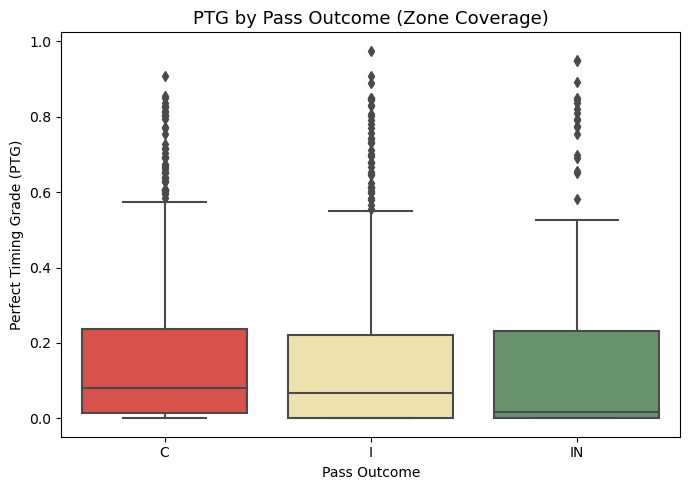

,median_ptg,mean_ptg,n
pass_result,,,
IN,0.017748,0.176565,145
I,0.066452,0.151096,737
C,0.080377,0.158920,986


In [ ]:
# Produce box plots for process validation

ptg_outcomes = (ptg_df_zone.merge(supp[['game_id', 'play_id', 'pass_result']], on=['game_id', 'play_id'], how='left').dropna(subset=['ptg', 'pass_result']))

import seaborn as sns 
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))

sns.boxplot(data=ptg_outcomes, x='pass_result', y='ptg', order=['C', 'I', 'IN'], palette=["#ee3d34", "#f5e9a4", "#5e9a65"])

plt.xlabel('Pass Outcome')
plt.ylabel('Perfect Timing Grade (PTG)')
plt.title('PTG by Pass Outcome (Zone Coverage)', fontsize=13)

plt.tight_layout()
plt.show()

ptg_outcomes.groupby('pass_result').agg(
    median_ptg=('ptg', 'median'),
    mean_ptg=('ptg', 'mean'),
    n=('ptg', 'count')
).sort_values('median_ptg')